<a target="_blank" href="https://colab.research.google.com/github/giordamaug/HELP/blob/main/HELPpy/notebooks/gui.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
<a target="_blank" href="https://www.kaggle.com/notebooks/welcome?src=https://github.com/giordamaug/HELP/blob/main/HELPpy/notebooks/gui.ipynb">
  <img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open In Colab"/>
</a>

### 1. Install HELP from GitHub
Skip this cell if you already have installed HELP.

In [ ]:
!pip install git+https://github.com/giordamaug/HELP.git

### 2. Download the input files
For a chosen tissue (here `Kidney`), download from GitHub the label file (here `Kidney_HELP.csv`, computed as in Example 1) and the attribute files (here BIO `Kidney_BIO.csv`, CCcfs `Kidney_CCcfs_1.csv`, ..., `Kidney_CCcfs_5.csv`, and N2V `Kidney_EmbN2V_128.csv`).  

Skip this step if you already have these input files locally.

In [ ]:
tissue='Kidney'
!wget https://raw.githubusercontent.com/giordamaug/HELP/main/data/{tissue}_HELP.csv
!wget https://raw.githubusercontent.com/giordamaug/HELP/main/data/{tissue}_BIO.csv
for i in range(5):
  !wget https://raw.githubusercontent.com/giordamaug/HELP/main/data/{tissue}_CCcfs_{i}.csv
!wget https://raw.githubusercontent.com/giordamaug/HELP/main/data/{tissue}_EmbN2V_128.csv

In [5]:
import ipywidgets as wid
from typing import List
import matplotlib.pyplot as plt
from HELPpy.models.labelling import labelling
from HELPpy.utility.selection import select_cell_lines, delrows_with_nan_percentage
from HELPpy.preprocess.loaders import feature_assemble
import pandas as pd
import numpy as np
import os, glob
from ipyfilechooser import FileChooser
from IPython.display import HTML as html_print
from IPython.display import display
from HELPpy.visualization.plot import svenn_intesect

def cstr(s, color='black'):
    return "<text style=color:{}>{}</text>".format(color, s)

def print_color(t):
    display(html_print(' '.join([cstr(ti, color=ci) for ti,ci in t])))
    
def pipeline(path: str=os.getcwd(), savepath: str=os.getcwd(), filename: str='', modelname:str='', rows: int=5, minlines=10, percent = 100.0, line_group='OncotreeLineage', line_col='ModelID', verbose=False):
    """
    Generate an interactive widget for labeling cell lines based on specified criteria.

    Parameters
    ----------
    path : str
        path for input file loading.
    filename : str
        name of CRISPR effect input file.
    modelname : str
        name of Model input file.
    rows : int, optional
        The number of rows to display in the widget for selecting tissues (default is 5).
    minlines : int, optional
        Minimum number of cell lines for tissue/lineage to be considered (default is 1).
    line_group : str, optional
        The column in 'df_map' to use for tissue selection (default is 'OncotreeLineage').
    line_col : str, optional
        The column in 'df_map' to use for line selection (default is 'ModelID').

    Returns
    -------
    ipywidgets.ValueWidget
        Widget containing the labeled cell lines.
    """
    tabs = wid.Tab()
    df_map = None
    df = None
    df_orig = None
    val = wid.ValueWidget()
    val.value = None, df, df_orig, df_map 
    tissue_list = []
    selector_list = []
    layout_visible = wid.Layout(visibility = 'visible')
    # NaN percentage widget
    nanrem_set = wid.SelectionSlider(
        options=range(0, 101),
        value=int(percent),
        description='Nan %:',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        tooltip='set percentage of nan allowed in genes',
    )
    def nanrem_set_changed(b):
        try:
            df_orig = val.value[2]
            df = delrows_with_nan_percentage(df_orig, perc=float(nanrem_set.value))
            try:
                df_map = val.value[3]
                tissue_list = [tissue for tissue in np.unique(df_map[selselector.value].dropna().values) 
                               if len(np.intersect1d(df.columns, df_map[df_map[selselector.value] == tissue][line_col].values)) >= minline_set.value]
                seltissue.options = ['__all__'] +  tissue_list
                seltissue.value=['__all__']
                val.value = val.value[0], df[np.intersect1d(df.columns,df_map[df_map[line_group].isin(tissue_list)][line_col].values)], val.value[2], val.value[3]
            except:
                val.value = val.value[0], df, val.value[2], val.value[3]
            with out3:
                out3.clear_output()
                print_color(((f'Removed {len(df_orig)-len(df)}/{len(df_orig)} rows (with at least {nanrem_set.value}% NaN)', 'green'),))
        except:
            pass 
    nanrem_set.observe(nanrem_set_changed, names='value')
    # Min lines widget
    minline_set = wid.SelectionSlider(
        options=range(1, 100),
        value=minlines,
        description='Min lines:',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        tooltip='set minimum number of lines for the tissue',
    )
    def minline_set_changed(b):
        df = val.value[1]
        df_map = val.value[3]
        try:
            tissue_list = [tissue for tissue in np.unique(df_map[selselector.value].dropna().values) if len(np.intersect1d(df.columns, df_map[df_map[selselector.value] == tissue][line_col].values)) >= minline_set.value]
            seltissue.options = ['__all__'] +  tissue_list
            seltissue.value=['__all__']
            val.value = val.value[0], df[np.intersect1d(df.columns, df_map[df_map[line_group].isin(tissue_list)][line_col].values)], val.value[2], val.value[3]
        except:
            val.value = val.value[0], df, val.value[2], val.value[3]
            with out1:
                out1.clear_output()
                print_color(((f'Problem processing map file ...', 'red'),)) 
    minline_set.observe(minline_set_changed, names='value')
    # Model column Selector widget
    selselector = wid.Dropdown(
        options=['__all__'] + selector_list,
        value='__all__',
        description='Selector:',
        tooltip = 'select the group type of lines',
        disabled=False,
    )
    def selselector_changed(b):
        df = val.value[1]
        df_map = val.value[3]
        if selselector.value != ():
            try:
                tissue_list = [tissue for tissue in np.unique(df_map[selselector.value].dropna().values) if len(np.intersect1d(df.columns, df_map[df_map[selselector.value] == tissue][line_col].values)) >= minline_set.value]
                seltissue.options = ['__all__'] +  tissue_list
                seltissue.value=['__all__']
                val.value = val.value[0], df[np.intersect1d(df.columns, df_map[df_map[line_group].isin(tissue_list)][line_col].values)], val.value[2], val.value[3]
            except:
                val.value = val.value[0], df, val.value[2], val.value[3]
                with out1:
                    out1.clear_output()
                    print_color(((f'Problem processing map file ...', 'red'),)) 
            with out1:
                out1.clear_output()
                display(selselector.value)
    selselector.observe(selselector_changed, names='value')
    # Tissue/Disease selection widget
    seltissue = wid.SelectMultiple(
        options=['__all__'] + tissue_list if tissue_list != [] else [],
        value=['__all__'] if tissue_list != [] else [],
        rows=rows,
        description=line_group if line_group in selselector.options else '',
        tooltip = 'select lines by the chosen group',
        disabled=False
    )
    def seltissue_changed(b):
        if seltissue.value != ():
            if seltissue.value == ('__all__',):
                fc3._filename.value = f"PanTissue.csv"
            else:
                fc3._filename.value = f"{'_'.join([str(s).replace(' ','-').replace('/','-') for s in seltissue.value if str(s) != '__all__'])}.csv"
            fc3._apply_selection()
            with out1:
                out1.clear_output()
                display(seltissue.value)
    seltissue.observe(seltissue_changed, names='value')
    # Save file chooser
    fc3 = FileChooser(savepath, title='Choose file', filter='*.csv')
    def fc3_change_title(fc3):
        fc3._label.value = fc3._LBL_TEMPLATE.format(f'Saving on {fc3.selected}', 'orange')
    fc3.register_callback(fc3_change_title)
    # Save button widget
    saveto_but = wid.Button(description="Save ...", button_style='primary')
    def on_savebutton_clicked(b):
        try:
            #fc3._label.value = fc3._LBL_TEMPLATE.format(f'{fc3.selected}', 'orange')
            labeldf = val.value[0]
            if labeldf is not None and len(labeldf)>0:
                val.value[0].to_csv(fc3.selected, index=True)
                fc3._label.value = fc3._LBL_TEMPLATE.format(f'Saved on {fc3.selected}', 'green')
            else:
                fc3._label.value = fc3._LBL_TEMPLATE.format(f'Problem saving {fc3.selected} (empty file)!', 'red')
        except:
            fc3._label.value = fc3._LBL_TEMPLATE.format(f'Problem saving {fc3.selected}!', 'red')
    saveto_but.on_click(on_savebutton_clicked)
    save_textbox = wid.Text(
        value="",
        description='',
    )
    save_textbox.layout = layout_visible
    # Class labelling selection widget
    mode_buttons = wid.RadioButtons(
        options=["E|NE", "E|aE|sNE", "E|(aE|sNE)"],
        value='E|NE',
        description='',
        tooltips=['2 classes (one division)', '3 classes (one division)', '3 classes (two-times subdivision)'],
    )
    # Mode labelling (mode of mode) widget
    selmode_button = wid.Checkbox(
        value=False,
        description='Nested',
        disabled=False,
        indent=False
    )
    # Labelling button widget
    button = wid.Button(description="Apply ...", button_style='primary')
    def on_button_clicked(b):
        df = val.value[1]
        df_map = val.value[3]
        with out1:
            out1.clear_output()
            print_color(((f'Labelling {len(df)} genes of {seltissue.value} ...', 'orange'),))
        with out2:
            out2.clear_output()
            if seltissue.value == ('__all__',):
                selector = [x for x in seltissue.options if x != '__all__']
            else:
                selector = [x for x in seltissue.value if x != '__all__']
            #display(selector)
            cell_lines = select_cell_lines(df, df_map, selector, line_group=line_group, line_col=line_col, 
                                            nested = selmode_button.value, verbose=verbose)
            if mode_buttons.value == "E|(aE|sNE)":
                mode = 'two-by-two' 
                nclasses = 3
                labelnames = {0: 'E', 1: 'aE', 2: 'sNE'}
            else:
                mode = 'flat-multi' 
                if mode_buttons.value == "E|NE":
                    nclasses = 2
                    labelnames = {0: 'E', 1: 'NE'}
                else:
                    nclasses = 3
                    labelnames = {0: 'E', 1: 'aE', 2: 'sNE'}
            val.value = labelling(df, columns=cell_lines, mode=mode, n_classes=nclasses, labelnames=labelnames, verbose=verbose), df, val.value[2], val.value[3]
        with out1:
            out1.clear_output()
            print_color(((f'DONE', 'green'),))
    button.on_click(on_button_clicked)
    # Output widgets
    out1 = wid.Output()
    out2 = wid.Output()
    out3 = wid.Output()
    out6 = wid.Output()

    # Input FileChooser widgets
    if filename != '':
        fc1 = FileChooser(path, title='Choose CRISPR effect file', filter='*.csv', filename=filename, select_default=True)
        try:
            df_orig = pd.read_csv(fc1.selected).rename(columns={'Unnamed: 0': 'gene'}).rename(columns=lambda x: x.split(' ')[0]).set_index('gene').T
            df = delrows_with_nan_percentage(df_orig, perc=float(nanrem_set.value))
            df_map = val.value[3]
            val.value = val.value[0],df, df_orig, val.value[3]
            with out3:
                out3.clear_output()
                print_color(((f'Removed {len(df_orig)-len(df)}/{len(df_orig)} rows (with at least {nanrem_set.value}% NaN)', 'green'),))
            if df_map is not None and len(np.unique(df_map[line_group].dropna().values)) > 0:
                try:
                    tissue_list = [tissue for tissue in np.unique(df_map[selselector.value].dropna().values) if len(np.intersect1d(df.columns, df_map[df_map[selselector.value] == tissue][line_col].values)) >= minline_set.value]
                    seltissue.options = ['__all__'] + tissue_list
                    seltissue.value=['__all__']
                    val.value = val.value[0], df[np.intersect1d(df.columns, df_map[df_map[line_group].isin(tissue_list)][line_col].values)], val.value[2], val.value[3]
                except:
                    val.value = val.value[0], df, val.value[2], val.value[3]
                    fc1._label.value = fc1._LBL_TEMPLATE.format(f'Problem reading {fc1.selected} file ...', 'red') 
            fc1._label.value = fc1._LBL_TEMPLATE.format(f'{fc1.selected}', 'green')
        except:
            fc1._label.value = fc1._LBL_TEMPLATE.format(f'Problem loading {fc1.selected} file ...', 'red') 
    else:
        fc1 = FileChooser(path, title='Choose CRISPR effect file', filter='*.csv')
    def fc1_change_title(fc1):
        #global df_map, df, df_orig
        try:
            df_orig = pd.read_csv(fc1.selected).rename(columns={'Unnamed: 0': 'gene'}).rename(columns=lambda x: x.split(' ')[0]).set_index('gene').T
            df = delrows_with_nan_percentage(df_orig, perc=float(nanrem_set.value))
            df_map = val.value[3]
            val.value = val.value[0],df ,df_orig, val.value[3]
            with out3:
                out3.clear_output()
                print_color(((f'Removed {len(df_orig)-len(df)}/{len(df_orig)} rows (with at least {nanrem_set.value}% NaN)', 'green'),))
            if df_map is not None and len(np.unique(df_map[line_group].dropna().values)) > 0:
                try:
                    tissue_list = [tissue for tissue in np.unique(df_map[selselector.value].dropna().values) if len(np.intersect1d(df.columns, df_map[df_map[selselector.value] == tissue][line_col].values)) >= minline_set.value]
                    seltissue.options = ['__all__'] + tissue_list
                    seltissue.value=['__all__']
                    val.value = val.value[0], df[np.intersect1d(df.columns, df_map[df_map[line_group].isin(tissue_list)][line_col].values)], val.value[2], val.value[3]
                except:
                    val.value = val.value[0], df, val.value[2], val.value[3]
                    fc1._label.value = fc1._LBL_TEMPLATE.format(f'Problem reading {fc1.selected} file ...', 'red') 
            fc1._label.value = fc1._LBL_TEMPLATE.format(f'{fc1.selected}', 'green')
        except:
            fc1._label.value = fc1._LBL_TEMPLATE.format(f'Problem loading {fc1.selected} file ...', 'red') 

    fc1.register_callback(fc1_change_title)
    if modelname != '':
        fc2 = FileChooser(path, title='Choose Model file', filter='*.csv', filename=modelname, select_default=True)
        try:
            df_map = pd.read_csv(fc2.selected)
            df = val.value[1]
            val.value = val.value[0], val.value[1] ,val.value[2], df_map
            selselector.options = list(df_map.columns)
            selselector.value = line_group if line_group in selselector.options else selselector.options[0]
            if len(np.unique(df_map[selselector.value].dropna().values)) > 0:
                try:
                    tissue_list = [tissue for tissue in np.unique(df_map[selselector.value].dropna().values) if len(np.intersect1d(df.columns, df_map[df_map[selselector.value] == tissue][line_col].values)) >= minline_set.value]
                    seltissue.options = ['__all__'] + tissue_list
                    seltissue.value=['__all__']
                    val.value = val.value[0], df[np.intersect1d(df.columns, df_map[df_map[line_group].isin(tissue_list)][line_col].values)], val.value[2], val.value[3]
                except:
                    val.value = val.value[0], df, val.value[2], val.value[3]
                    fc2._label.value = fc2._LBL_TEMPLATE.format(f'Problem reading {fc2.selected} file ...', 'red') 
            fc2._label.value = fc2._LBL_TEMPLATE.format(f'{fc2.selected}', 'green')
        except:
            fc2._label.value = fc2._LBL_TEMPLATE.format(f'Problem loading {fc2.selected} file ...', 'red') 
    else:
        fc2 = FileChooser(path, title='Choose Model file', filter='*.csv')
    def fc2_change_title(fc2):
        #global df_map, df
        try:
            df_map = pd.read_csv(fc2.selected)
            df = val.value[1]
            val.value = val.value[0], val.value[1] ,val.value[2], df_map
            selselector.options = list(df_map.columns)
            selselector.value = line_group if line_group in selselector.options else selselector.options[0]
            if len(np.unique(df_map[selselector.value].dropna().values)) > 0:
                try:
                    tissue_list = [tissue for tissue in np.unique(df_map[selselector.value].dropna().values) if len(np.intersect1d(df.columns, df_map[df_map[selselector.value] == tissue][line_col].values)) >= minline_set.value]
                    seltissue.options = ['__all__'] + tissue_list
                    seltissue.value=['__all__']
                    val.value = val.value[0], df[np.intersect1d(df.columns, df_map[df_map[line_group].isin(tissue_list)][line_col].values)], val.value[2], val.value[3]
                except:
                    val.value = val.value[0], df, val.value[2], val.value[3]
                    fc2._label.value = fc2._LBL_TEMPLATE.format(f'Problem reading {fc2.selected} file ...', 'red') 
            fc2._label.value = fc2._LBL_TEMPLATE.format(f'{fc2.selected}', 'green')
        except:
            fc2._label.value = fc2._LBL_TEMPLATE.format(f'Problem loading {fc2.selected} file ...', 'red') 
    fc2.register_callback(fc2_change_title)

    files = wid.SelectMultiple(
        description='Files',
        options=glob.glob('{}/*'.format(savepath))
    )
    setbut = wid.Button(description="Intersect ...", button_style='primary')
    def on_setbut_clicked(b):
        csEGs = []
        for f in files.value:
            dfl = pd.read_csv(f, index_col=0)
            csEGs += [dfl[dfl['label'] == 'E'].index.values]
            df_common = pd.read_csv(os.path.join(savepath,'PanTissue_mom.csv'), index_col=0)
            cEG = df_common[df_common['label']=='E'].index.values
            EGs = [set(np.setdiff1d(eg, cEG)) for eg in csEGs]
        with out6:
            out6.clear_output()
            svenn_intesect(EGs, labels=[x.split('/')[-1].split('.')[0] for x in files.value], ylabel='EGs', figsize=(10,4))
    setbut.on_click(on_setbut_clicked)

    Vb1 = wid.VBox([nanrem_set, setbut, out3], layout=wid.Layout(overflow='auto'))
    Vb2 = wid.VBox([fc1, fc2])
    Vb3 = wid.VBox([minline_set, selselector, wid.HBox([seltissue, selmode_button], layout=wid.Layout(overflow='auto'))], layout=wid.Layout(overflow='auto'))
    Vb4 = wid.VBox([wid.VBox([mode_buttons, wid.HBox([button, out1], layout=wid.Layout(overflow='auto'))]),  out2], layout=wid.Layout(overflow='auto'))
    Vb5 = wid.VBox([wid.HBox([fc3, saveto_but])], layout=wid.Layout(overflow='auto'))
    Vb6 = wid.VBox([wid.HBox([files, setbut]), out6])
    tabs.children = [Vb2, Vb1, Vb3 ,Vb4, Vb5, Vb6]
    tabs.set_title(1, 'NaN removal')
    tabs.set_title(0, 'File input')
    tabs.set_title(2, 'Line filtering')
    tabs.set_title(3, 'Labelling')
    tabs.set_title(4, 'Saving')
    tabs.set_title(5, 'Interset')
    display(tabs)
    #print(tissue_list)
    return val

Observe that the CCcfs file has been subdivided into 5 separate files for storage limitations on GitHub. 

### 3. Load the input files
Load the CRISPR data and show the content.

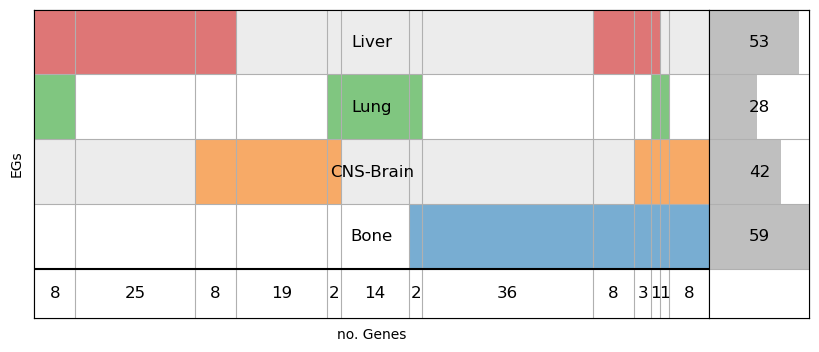

In [6]:
w = pipeline(path='../../data', 
             savepath='../../newdata', 
             filename='CRISPRGeneEffect.csv', 
             modelname='Model.csv')

In [45]:
w.value[1]

gene,ACH-000001,ACH-000004,ACH-000005,ACH-000007,ACH-000009,ACH-000011,ACH-000012,ACH-000013,ACH-000015,ACH-000017,...,ACH-002693,ACH-002710,ACH-002785,ACH-002799,ACH-002800,ACH-002834,ACH-002847,ACH-002922,ACH-002925,ACH-002926
A1BG,-0.122637,0.019756,-0.107208,-0.031027,0.008888,0.022670,-0.096631,0.049811,-0.099040,-0.044896,...,-0.072582,-0.033722,-0.053881,-0.060617,0.025795,-0.055721,-0.009973,-0.025991,-0.127639,-0.068666
A1CF,0.025881,-0.083640,-0.023211,-0.137850,-0.146566,-0.057743,-0.024440,-0.158811,-0.070409,-0.115830,...,-0.237311,-0.108704,-0.114864,-0.042591,-0.132627,-0.121228,-0.119813,-0.007706,-0.040705,-0.107530
A2M,0.034217,-0.060118,0.200204,0.067704,0.084471,0.079679,0.041922,-0.003968,-0.029389,0.024537,...,-0.065940,0.079277,0.069333,0.030989,0.249826,0.072790,0.044097,-0.038468,0.134556,0.067806
A2ML1,-0.128082,-0.027417,0.116039,0.107988,0.089419,0.227512,0.039121,0.034778,0.084594,-0.003710,...,0.101541,0.038977,0.066599,0.043809,0.064657,0.021916,0.041358,0.236576,-0.047984,0.112071
A3GALT2,-0.031285,-0.036116,-0.172227,0.007992,0.065109,-0.130448,0.028947,-0.120875,-0.052288,-0.336776,...,0.005374,-0.144070,-0.256227,-0.116473,-0.294305,-0.221940,-0.146565,-0.239690,-0.116114,-0.149897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,-0.289724,0.032983,-0.201273,-0.100344,-0.112703,0.013401,0.005124,-0.089180,-0.005409,-0.070396,...,-0.296880,-0.084936,-0.128569,-0.110504,-0.087171,0.024959,-0.119911,-0.079342,-0.043555,-0.045115
ZYG11B,-0.062972,-0.410392,-0.178877,-0.462160,-0.598698,-0.296421,-0.131949,-0.145737,-0.216393,-0.257916,...,-0.332415,-0.193408,-0.327408,-0.257879,-0.349111,0.015259,-0.289412,-0.347484,-0.335270,-0.307900
ZYX,0.074180,0.113156,-0.055349,-0.001555,0.095877,0.067705,-0.109147,-0.034886,-0.137350,0.029457,...,-0.005090,-0.218960,-0.053033,-0.041612,-0.057478,-0.306562,-0.195097,-0.085302,-0.208063,0.070671
ZZEF1,0.111244,0.234388,-0.002161,-0.325964,-0.026742,-0.232453,-0.164482,-0.175850,-0.168087,-0.284838,...,-0.188751,-0.120449,-0.267081,0.006148,-0.189602,-0.148368,-0.206400,-0.095965,-0.094741,-0.187813


In [40]:
w.value[0].value_counts()

label
NE       16695
E         1236
Name: count, dtype: int64

In [39]:
pd.read_csv("../../data/Lung_HELP.csv", index_col=0).value_counts()

label
sNE      13847
aE        2849
E         1235
Name: count, dtype: int64

In [ ]:
tissue for tissue in np.unique(df_map[selselector.value].dropna().values) 
if len(np.intersect1d(df.columns, df_map[df_map[selselector.value] == tissue][line_col].values)) >= minline_set.value]


In [40]:
pd.read_csv("../newdata/Kidney.csv", index_col=0).value_counts()

label
NE       16678
E         1253
Name: count, dtype: int64

In [41]:
pd.read_csv("../data/Kidney_HELP.csv", index_col=0).replace({'aE': 'NE', 'sNE': 'NE'}).value_counts()

label
NE       16678
E         1253
Name: count, dtype: int64

In [5]:
w.value[0].value_counts()

label
NE       16681
E         1250
Name: count, dtype: int64

In [46]:
from HELPpy.utility.selection import select_cell_lines
from HELPpy.utility.selection import delrows_with_nan_percentage
from HELPpy.utility.selection import filter_crispr_by_model
from HELPpy.models.labelling import labelling
import pandas as pd
import os
df_orig = pd.read_csv("CRISPRGeneEffect.csv").rename(columns={'Unnamed: 0': 'gene'}).rename(columns=lambda x: x.split(' ')[0]).set_index('gene').T
print(f'{df_orig.isna().sum().sum()} NaNs over {len(df_orig)*len(df_orig.columns)} values')
df_map = pd.read_csv("Model.csv")
# remove rows with more than perc NaNs
df_nonan = delrows_with_nan_percentage(df_orig, perc=95)
df = filter_crispr_by_model(df_nonan, df_map, minlines=10, line_group='OncotreeLineage')
cell_lines = select_cell_lines(df, df_map, tissue_list=['Lung'], nested=False)
print(f"Selecting {len(cell_lines)} tissues for a total of {sum([len(x) for x in cell_lines])} cell-lines")
# remove rows with all nans
df_common = labelling(df_nonan, columns=cell_lines, n_classes=3, labelnames={0:'E', 1: 'aE', 2: 'sNE'}, mode='two-by-two', algorithm='otsu')
df_common.value_counts()


FileNotFoundError: [Errno 2] No such file or directory: 'CRISPRGeneEffect.csv'

In [8]:
pd.read_csv("../../newdata/PanTissue_mom.csv", index_col=0).value_counts()

label
NE       16689
E         1242
Name: count, dtype: int64

In [2]:
import pandas as pd
df_map = pd.read_csv("../../data/Model.csv")
df = pd.read_csv("../../data/CRISPRGeneEffect.csv").rename(columns={'Unnamed: 0': 'gene'}).rename(columns=lambda x: x.split(' ')[0]).set_index('gene').T
from HELPpy.utility.selection import select_cell_lines
select_cell_lines(df, df_map, ['Kidney', 'Lung'])

['ACH-000159',
 'ACH-000189',
 'ACH-000234',
 'ACH-000246',
 'ACH-000250',
 'ACH-000262',
 'ACH-000272',
 'ACH-000313',
 'ACH-000317',
 'ACH-000375',
 'ACH-000385',
 'ACH-000411',
 'ACH-000433',
 'ACH-000459',
 'ACH-000484',
 'ACH-000495',
 'ACH-000533',
 'ACH-000597',
 'ACH-000649',
 'ACH-000684',
 'ACH-000709',
 'ACH-000792',
 'ACH-000907',
 'ACH-001099',
 'ACH-001128',
 'ACH-001163',
 'ACH-001194',
 'ACH-001211',
 'ACH-001212',
 'ACH-001310',
 'ACH-001398',
 'ACH-001532',
 'ACH-001687',
 'ACH-001688',
 'ACH-002150',
 'ACH-002189',
 'ACH-002533',
 'ACH-000012',
 'ACH-000015',
 'ACH-000021',
 'ACH-000029',
 'ACH-000030',
 'ACH-000035',
 'ACH-000143',
 'ACH-000161',
 'ACH-000176',
 'ACH-000187',
 'ACH-000251',
 'ACH-000257',
 'ACH-000261',
 'ACH-000264',
 'ACH-000290',
 'ACH-000292',
 'ACH-000311',
 'ACH-000337',
 'ACH-000339',
 'ACH-000343',
 'ACH-000355',
 'ACH-000378',
 'ACH-000390',
 'ACH-000395',
 'ACH-000414',
 'ACH-000416',
 'ACH-000431',
 'ACH-000434',
 'ACH-000438',
 'ACH-0004

In [3]:
df

gene,ACH-000001,ACH-000004,ACH-000005,ACH-000007,ACH-000009,ACH-000011,ACH-000012,ACH-000013,ACH-000015,ACH-000017,...,ACH-002693,ACH-002710,ACH-002785,ACH-002799,ACH-002800,ACH-002834,ACH-002847,ACH-002922,ACH-002925,ACH-002926
A1BG,-0.122637,0.019756,-0.107208,-0.031027,0.008888,0.022670,-0.096631,0.049811,-0.099040,-0.044896,...,-0.072582,-0.033722,-0.053881,-0.060617,0.025795,-0.055721,-0.009973,-0.025991,-0.127639,-0.068666
A1CF,0.025881,-0.083640,-0.023211,-0.137850,-0.146566,-0.057743,-0.024440,-0.158811,-0.070409,-0.115830,...,-0.237311,-0.108704,-0.114864,-0.042591,-0.132627,-0.121228,-0.119813,-0.007706,-0.040705,-0.107530
A2M,0.034217,-0.060118,0.200204,0.067704,0.084471,0.079679,0.041922,-0.003968,-0.029389,0.024537,...,-0.065940,0.079277,0.069333,0.030989,0.249826,0.072790,0.044097,-0.038468,0.134556,0.067806
A2ML1,-0.128082,-0.027417,0.116039,0.107988,0.089419,0.227512,0.039121,0.034778,0.084594,-0.003710,...,0.101541,0.038977,0.066599,0.043809,0.064657,0.021916,0.041358,0.236576,-0.047984,0.112071
A3GALT2,-0.031285,-0.036116,-0.172227,0.007992,0.065109,-0.130448,0.028947,-0.120875,-0.052288,-0.336776,...,0.005374,-0.144070,-0.256227,-0.116473,-0.294305,-0.221940,-0.146565,-0.239690,-0.116114,-0.149897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,-0.289724,0.032983,-0.201273,-0.100344,-0.112703,0.013401,0.005124,-0.089180,-0.005409,-0.070396,...,-0.296880,-0.084936,-0.128569,-0.110504,-0.087171,0.024959,-0.119911,-0.079342,-0.043555,-0.045115
ZYG11B,-0.062972,-0.410392,-0.178877,-0.462160,-0.598698,-0.296421,-0.131949,-0.145737,-0.216393,-0.257916,...,-0.332415,-0.193408,-0.327408,-0.257879,-0.349111,0.015259,-0.289412,-0.347484,-0.335270,-0.307900
ZYX,0.074180,0.113156,-0.055349,-0.001555,0.095877,0.067705,-0.109147,-0.034886,-0.137350,0.029457,...,-0.005090,-0.218960,-0.053033,-0.041612,-0.057478,-0.306562,-0.195097,-0.085302,-0.208063,0.070671
ZZEF1,0.111244,0.234388,-0.002161,-0.325964,-0.026742,-0.232453,-0.164482,-0.175850,-0.168087,-0.284838,...,-0.188751,-0.120449,-0.267081,0.006148,-0.189602,-0.148368,-0.206400,-0.095965,-0.094741,-0.187813
